<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>

# 01 Thresholding

Before diving into any data analysis endeavor, we must first clean our scans. Raw X-ray CT reconstructions, as most real-life data, is quite messy and there are a number of issues to be addressed. 

- Remove the air and other debris
- Separating individual fruits

Needless to say, this image processing pipeline uses only basic mathematical morphology operations and the parameters are _ad-hoc_ for the data at hand.

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/crc_pics/crc_diversity.jpg" alt = "barley" style="width:375px;"/>
        <p style="text-align:center;font-size:20px"><strong>UCR Citrus Colleciton</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/crc_pics/citrus_xrayct_scanning.jpeg" alt = "Website icon" style="width:375px;"/>
        <p style="text-align:center;font-size:20px"><strong>X-ray CT scanning</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_CRC3289_12B-19-9_L01_raw.gif" alt="NSF Logo" style="width:220px">
        <p style="text-align:center;font-size:20px"><strong>Raw scans</strong></p>
    </td>
  </tr>
</tbody>
</table>

In [2]:
import tifffile as tf
import numpy as np
import os
from matplotlib import pyplot as plt
import math
import importlib
import unionfind as UF

import scipy.ndimage as ndimage

import pandas as pd

### Load raw scan. 

- The scans are usually 2Gb in size and contain 3 individual fruits to be separated
- `dst` path to store details on the bounding boxes of individual fruits
    - More details of these boxes below

In [3]:
dst = '../preproc/masks/'
#filepath  = '../preproc/raw/SW01_CRC3030_12B-8-5_beam.tif'
#filepath = '../preproc/raw/SW02_CRC3746_12B-17-7_beam.tif'
#filepath = '../preproc/raw/SW03_CRC1241-B_12B-4-3_beam.tif'

filepath = '../preproc/raw/WR09_CRC3469_12B-36-9_beam.tif'
#filepath = '../preproc/raw/WR18_CRC2863_12A-39-9_beam.tif'

In [3]:
_ , fname = os.path.split(filepath)
bname = os.path.splitext(fname)[0][:-5]
bname

'WR09_CRC3469_12B-36-9'

In [4]:
img = tf.imread(filepath)

### Find local maxima

- In this case, we use 0-level persistence
- See https://github.com/amezqui3/demeter/blob/main/jupyter/01_density_groundtruth.ipynb for more details

In [7]:
def persistence_with_UF(img, showfig=True, writefig=False, bname='file.jpg', dst='./', dpi=100):
    hist0,bins = np.histogram(img,bins=2**(img.dtype.itemsize*8),range=(0,2**(img.dtype.itemsize*8)))
    pers = sorted(UF.persistence(hist0),reverse=True)
    if showfig:
        plt.figure(figsize=(15,5))
        plt.plot(np.log(hist0+1), lw=3)
        plt.title(bname, fontsize=20);
        
        if writefig:
            filename = dst + bname + '.jpg'
            plt.savefig(filename, dpi=dpi, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight');
            plt.close()
    return pers

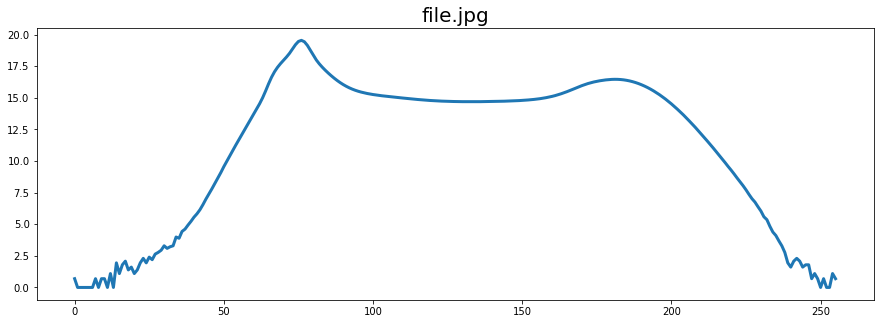

In [8]:
pers = persistence_with_UF(img, bname=bname)

In [9]:
pers

[(inf, None, 76),
 (11779651, 132, 181),
 (1618, 134, 133),
 (5, 240, 242),
 (5, 35, 34),
 (5, 31, 30),
 (5, 20, 17),
 (4, 15, 14),
 (3, 24, 23),
 (2, 250, 254),
 (2, 26, 25),
 (2, 13, 12),
 (1, 252, 251),
 (1, 247, 248),
 (1, 244, 246),
 (1, 18, 19),
 (1, 11, 10),
 (1, 8, 7),
 (1, 1, 0)]

### Threshold at the midpoint between the two most prominent local maxima

- Once thresholded, remove all the planes that are purely zeros
- This should reduce the image size noticeably and make further manipulation easier
- After this step, we have a _zero-cleaned_ image
- We keep track in `cero` of how many zero-planes were removed from the original image in each direction

In [11]:
thr = math.ceil((pers[0][-1] + pers[1][-1])*.5)
img[img < thr] = 0

In [12]:
def clean_zeroes(img):
    dim = img.ndim
    orig_size = img.size

    cero = list(range(2*dim))

    for k in range(dim):
        ceros = np.all(img == 0, axis = (k, (k+1)%dim))

        for i in range(len(ceros)):
            if(~ceros[i]):
                break
        for j in range(len(ceros)-1, 0, -1):
            if(~ceros[j]):
                break
        cero[k] = i
        cero[k+dim] = j+1

    img = img[cero[1]:cero[4], cero[2]:cero[5], cero[0]:cero[3]]

    print(round(100-100*img.size/orig_size),'% reduction from input')

    return img, cero

In [13]:
img, cero = clean_zeroes(img)
cero

30 % reduction from input


[58, 112, 53, 1700, 940, 1565]

### Get the coordinates of separate connected components

- Each connected component should correspond to an individual fruit
- We get the _coordinates_ of the connected component, **not** the connected component itself. That will be done later.
- More specifically, we get a bounding box that should contain the whole individual fruit.

- The coordinates are stored in an $(n+1)\times7$ vector
```
boxes[i] = (z0, y0, x0, z1, y1, x1, thr)
```
- `x0, y0, z0` correspond to the $(x,y,z)$ coordinates _thresholded and zero-cleaned image_ of the lower, left corner of the bounding box
- `x1, y1, z1` correspond to the upper, right, opposite corner of the box
- `thr` is the threshold applied to the raw image
- `n` is the number of individual connected componets.
    - Each component must have at least 1% of the total nonzero voxels, else it is considered debris.
- The last row contains the number of zero-valued planes removed across each of the 6 directions

In [15]:
def get_comp_boxes(img, cero, thr, cutoff = 1e-2):
    labels,num = ndimage.label(img, structure=ndimage.generate_binary_structure(img.ndim, 1))
    print(num,'components')
    hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
    regions = ndimage.find_objects(labels)
    sz_hist = np.sum(hist)
    argsort_hist = np.argsort(hist)[::-1]
    boxes = np.zeros((np.sum(hist/sz_hist > cutoff)+1, 7), dtype=int)
    print(boxes.shape)
    idx = 0
    for j in range(len(regions)):
        i = argsort_hist[j]
        r = regions[i]
        if(hist[i]/sz_hist > 1e-2):
            boxes[idx, :6] = r[0].start, r[1].start, r[2].start, r[0].stop, r[1].stop, r[2].stop
            idx += 1
        boxes[-1, :6] = cero[1], cero[2], cero[0], cero[4], cero[5], cero[3]
    boxes[:,-1] = thr
    
    return boxes

In [16]:
boxes = get_comp_boxes(img, cero, thr)
boxes

21903 components
(4, 7)


### Store the `boxes` matrix

In [18]:
dfboxes = pd.DataFrame(boxes, columns=['z0','y0','x0','z1','y1','x1','thr'])
filename = dst + bname + '.csv'
dfboxes.to_csv(filename, index=False)